In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Bidirectional, concatenate, GRU, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


### Load training and Validation arrays

In [3]:
dict_genres = {'Blues':0, 'Classical':1, 'Country':2, 'Disco':3, 'Hip-Hop':4, 'Jazz':5, 'Metal':6, 'Pop':7, 'Reggae':8, 'Rock':9}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Disco', 4: 'Hip-Hop', 5: 'Jazz', 6: 'Metal', 7: 'Pop', 8: 'Reggae', 9: 'Rock'}


In [4]:
npzfile = np.load('data/all_targets_sets_train_new.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(7990, 128, 128) (7990, 10)


In [5]:
npzfile = np.load('data/all_targets_sets_valid_new.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(1000, 128, 128) (1000, 10)


### Check by plotting a Spectogram

Disco
(128, 128)


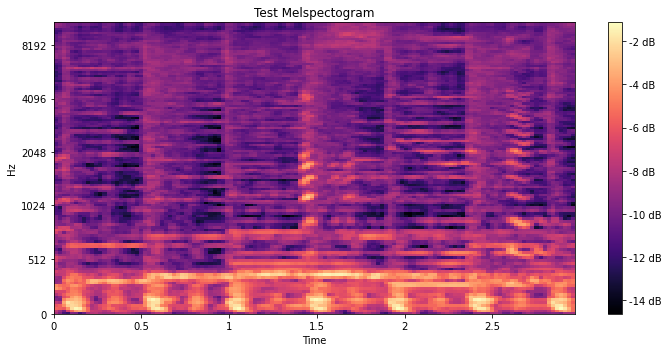

In [6]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
print(spectogram.shape)
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### Parallel CNN - RNN Model

In [7]:
batch_size = 32
num_classes = 10
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [8]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding='valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding='valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding='valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding='valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation='softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
def train_model(x_train, y_train, x_val, y_val):
    n_frames = 128
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/parallel/"+datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [10]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14,

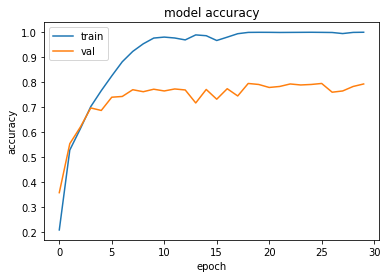

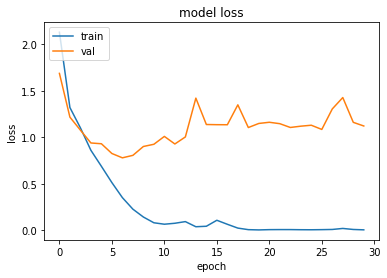

In [11]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)
show_summary_stats(history)

In [12]:
npzfile = np.load('data/all_targets_sets_test_new.npz')
print(npzfile.files)

X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(1000, 128, 128) (1000, 10)


In [13]:
y_test = np.argmax(y_test, axis= -1)

In [14]:
from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

(1000,) (1000,)
              precision    recall  f1-score   support

       Blues       0.81      0.79      0.80       100
   Classical       0.92      0.92      0.92       100
     Country       0.75      0.70      0.73       100
       Disco       0.76      0.79      0.77       100
     Hip-Hop       0.78      0.85      0.81       100
        Jazz       0.86      0.84      0.85       100
       Metal       0.85      0.89      0.87       100
         Pop       0.74      0.78      0.76       100
      Reggae       0.78      0.78      0.78       100
        Rock       0.70      0.62      0.66       100

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.79      1000
weighted avg       0.80      0.80      0.79      1000



Text(91.68, 0.5, 'predicted label')

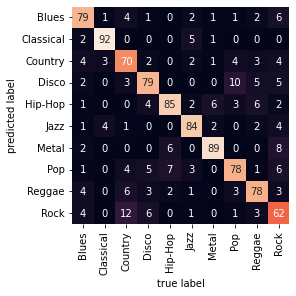

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label')

In [16]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.796


In [17]:
def create_spectogram(AUDIO_DIR):
    y, sr = librosa.load(AUDIO_DIR)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [18]:
def plot_spect(AUDIO_DIR):
    spect = create_spectogram(AUDIO_DIR)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [19]:
#AUDIO_DIR = 'demo/Nirvana-Smells Like Teen Spirit.mp3'
AUDIO_DIR = 'demo/Maroon 5 - She Will Be Loved.mp3'

In [20]:
spect = create_spectogram(AUDIO_DIR)
#spect = spect[:128, :]

C:\Users\Gabriele\anaconda3\envs\music-genre-recognition\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [21]:
spect_raw = librosa.core.db_to_power(spect, ref=1.0)
spect = np.log(spect_raw)

print(np.amin(spect_raw), np.amax(spect_raw), np.mean(spect_raw))

1e-08 1.0 0.002994558


In [22]:
spect = np.expand_dims(spect, axis = -1)
#spect = np.expand_dims(spect, axis = 0)
spect.shape

(5550, 128, 1)

In [23]:
_arr = []
for i in range(spect.shape[0]//128):
    frame = spect[128*i:128*(i+1), :]
    if frame.shape[0] == 128:
        _arr.append(frame)
#        print("ok")
#    print(str(128*i)+":"+str(128*(i+1)))
#    print(frame.shape)
    
_arr = np.array(_arr)

In [24]:
_arr.shape

(43, 128, 128, 1)

In [25]:
y_pred_single = model.predict(_arr)
#print(list(dict_genres.keys())[list(dict_genres.values()).index(y_pred_single[0])])

In [ ]:
y_pred_single

In [26]:
np.argmax(y_pred_single, axis=-1)

array([8, 8, 8, 8, 8, 7, 7, 8, 7, 7, 7, 7, 5, 8, 8, 8, 7, 7, 8, 7, 7, 9,
       7, 7, 7, 9, 0, 7, 7, 8, 8, 7, 7, 7, 5, 7, 7, 5, 7, 1, 7, 1, 1],
      dtype=int64)

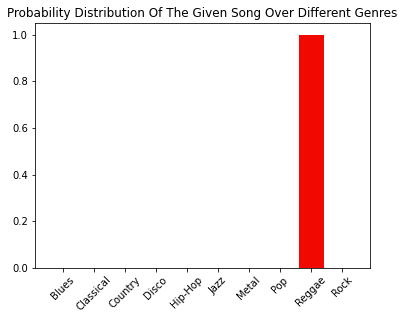

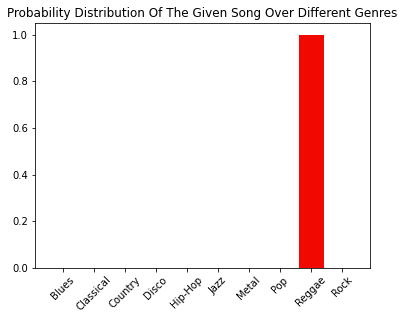

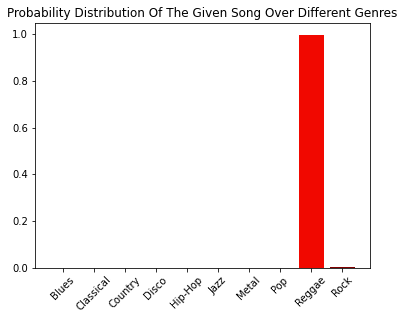

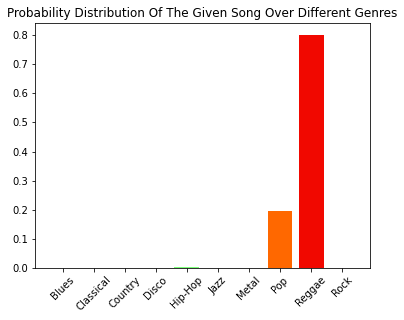

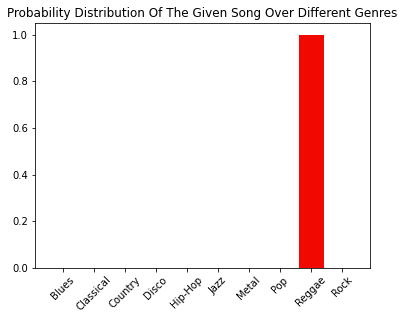

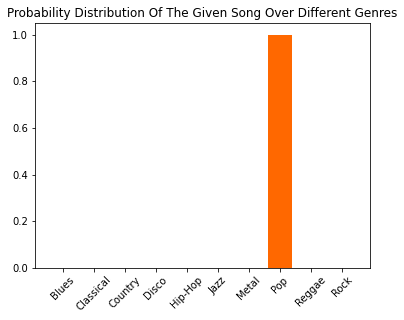

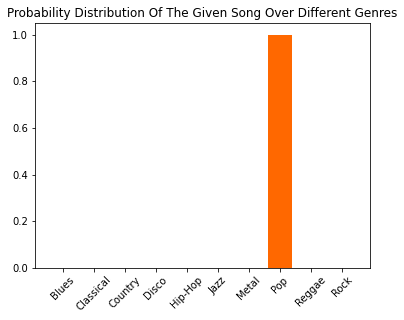

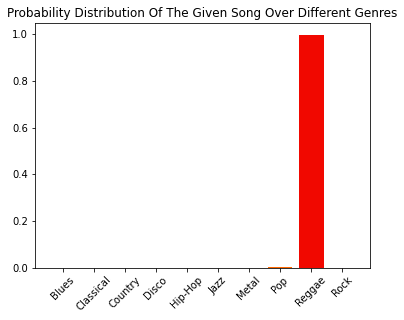

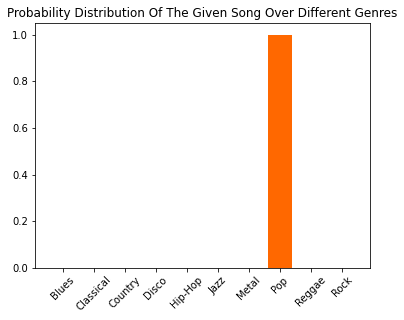

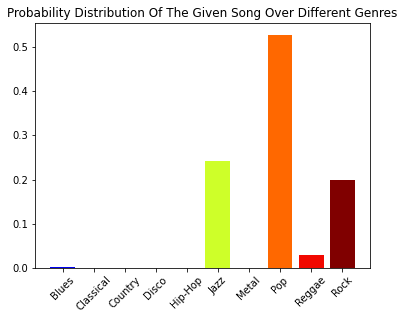

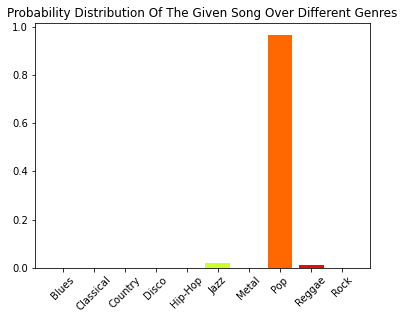

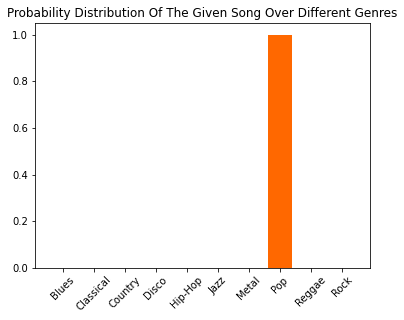

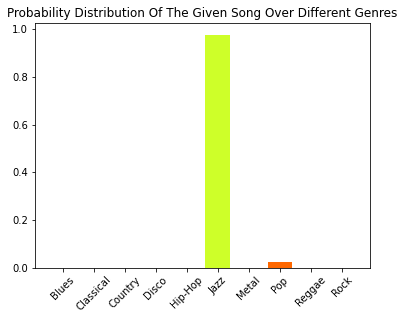

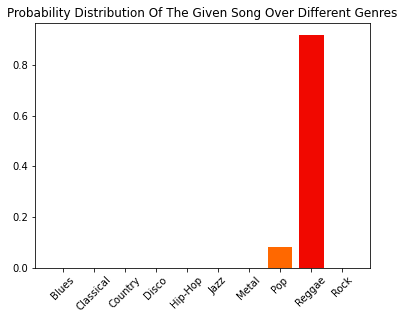

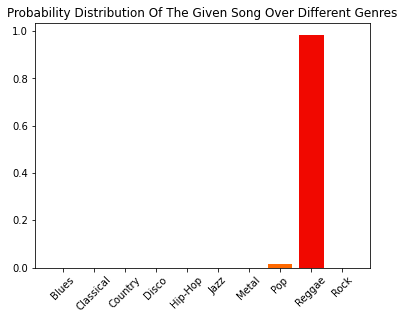

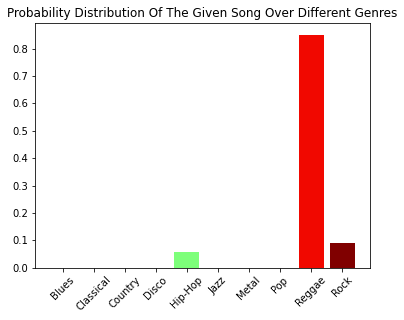

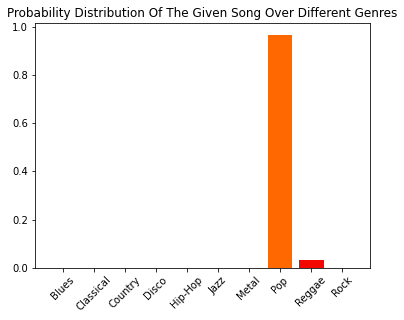

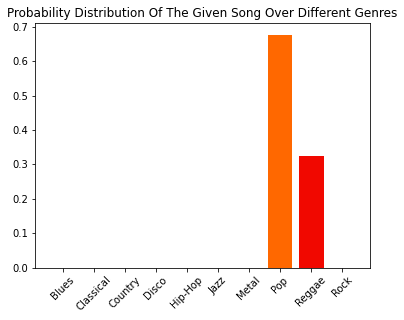

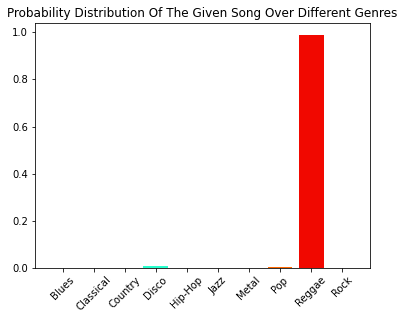

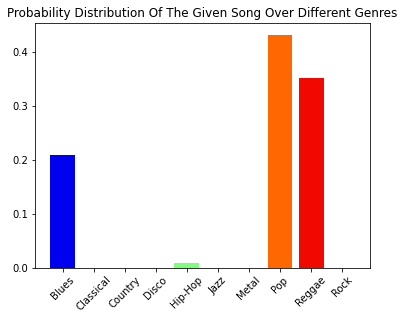

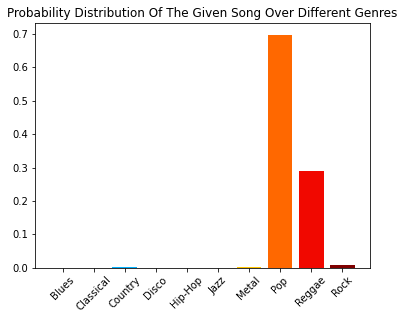

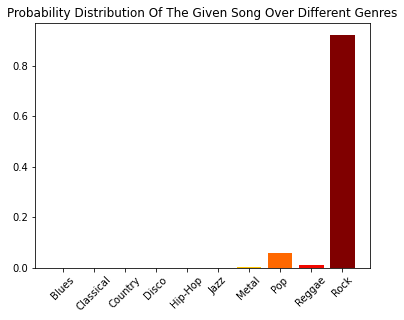

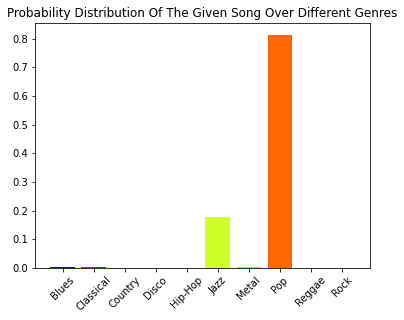

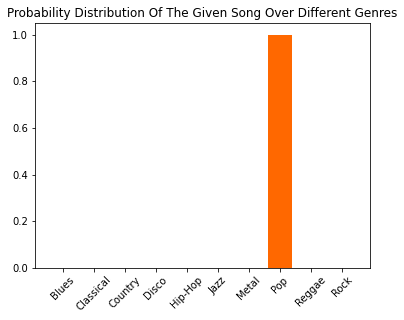

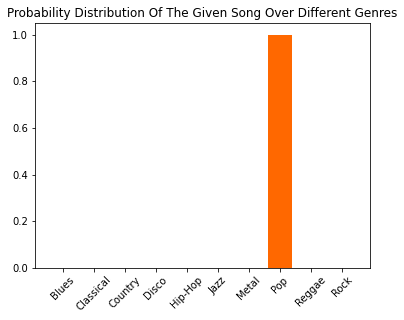

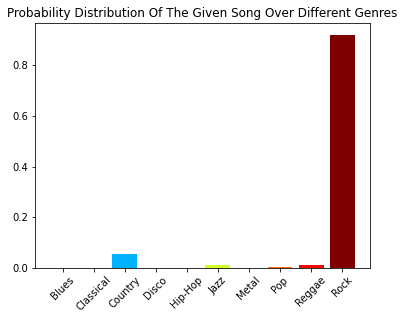

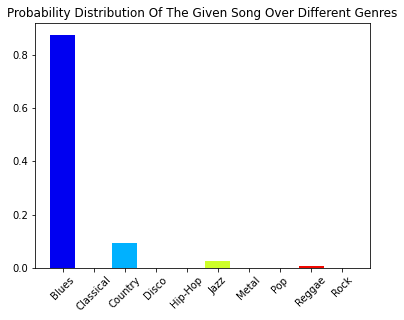

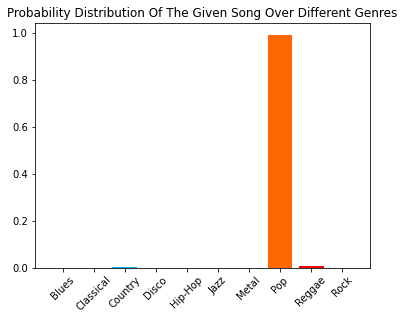

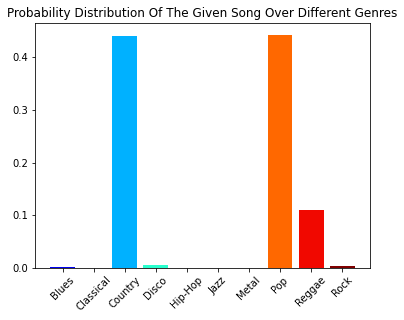

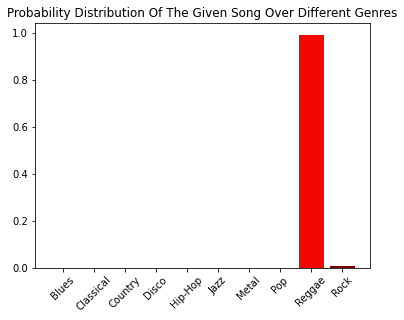

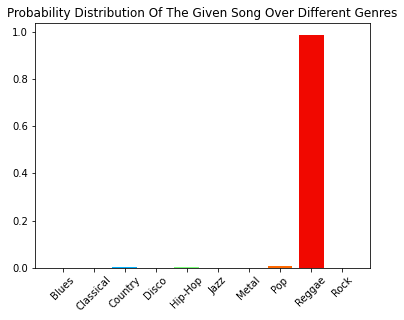

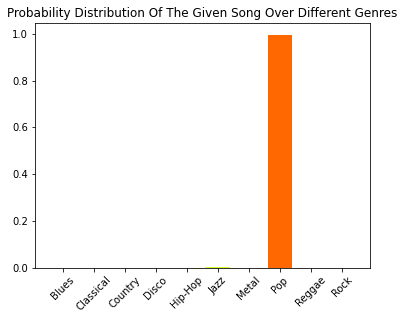

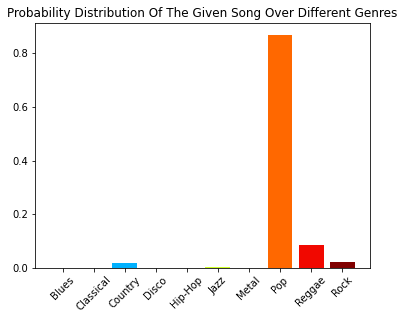

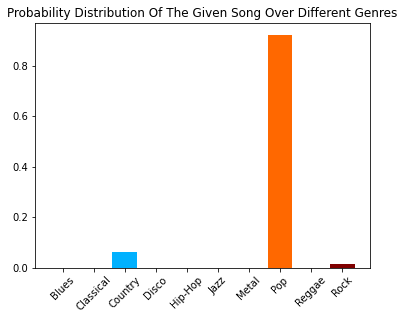

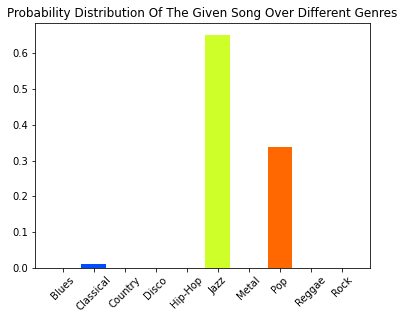

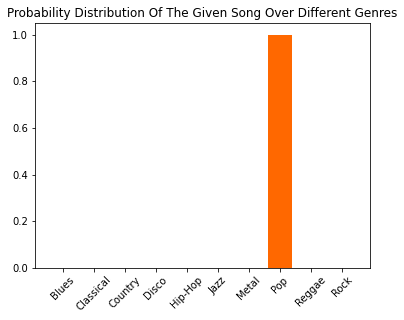

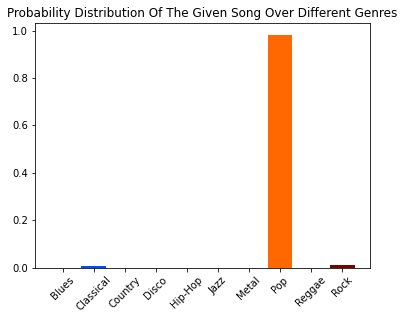

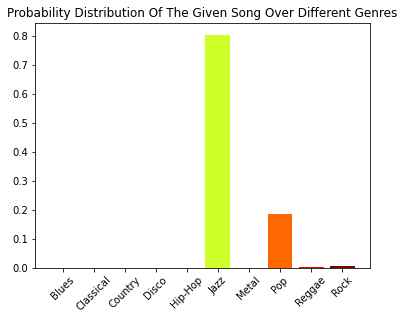

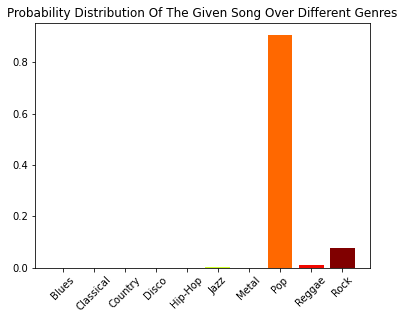

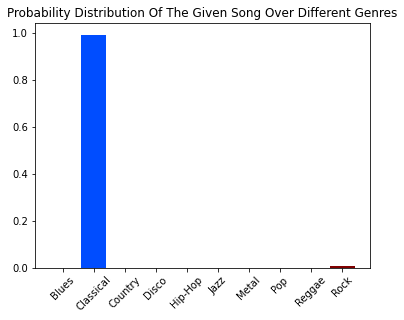

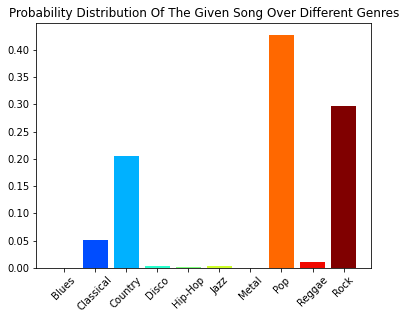

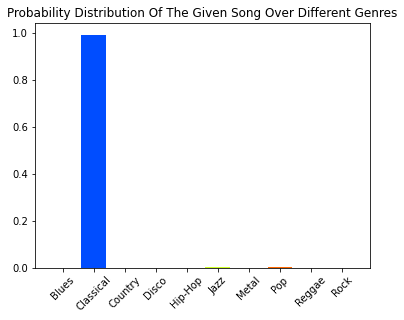

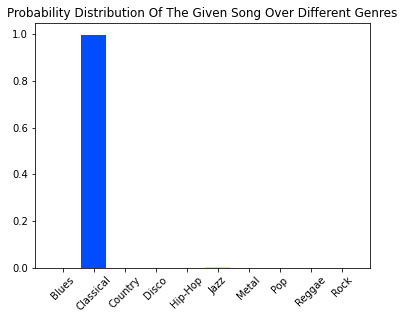

In [27]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

my_norm = Normalize(vmin=0, vmax=10)
my_cmap = cm.get_cmap('jet')
color_data = [1,2,3,4,5,6,7,8,9,10]

for i in range(y_pred_single.shape[0]):
    prediction = y_pred_single[i].reshape((10,))

    fig,ax= plt.subplots(figsize=(6,4.5))
    ax.bar(x=list(dict_genres.keys()),height=prediction,color=my_cmap(my_norm(color_data)))
    plt.xticks(rotation=45)
    ax.set_title("Probability Distribution Of The Given Song Over Different Genres")

    plt.show()